In [444]:
%matplotlib inline
import cv2
import csv
import os
import numpy as np
import pandas as pd
import random
import argparse
from tqdm import tqdm
from loader_utils import *
from matplotlib import pyplot as plt
import matplotlib.patches as patches

#plt.rcParams['figure.figsize'] = [10,10]


In [2]:
CSV_PATH = "/home/paolobif/Lab-Work/ml/pre_arch/worm_data/compiled_11_20/compiled_11_20.csv"
IMAGE_PATH = "/home/paolobif/Lab-Work/ml/pre_arch/worm_data/compiled_11_20/NN_posttrain_2_im/"

# load image names
# load csv
image_names = os.listdir(IMAGE_PATH)
csv_ar = load_csv(CSV_PATH)


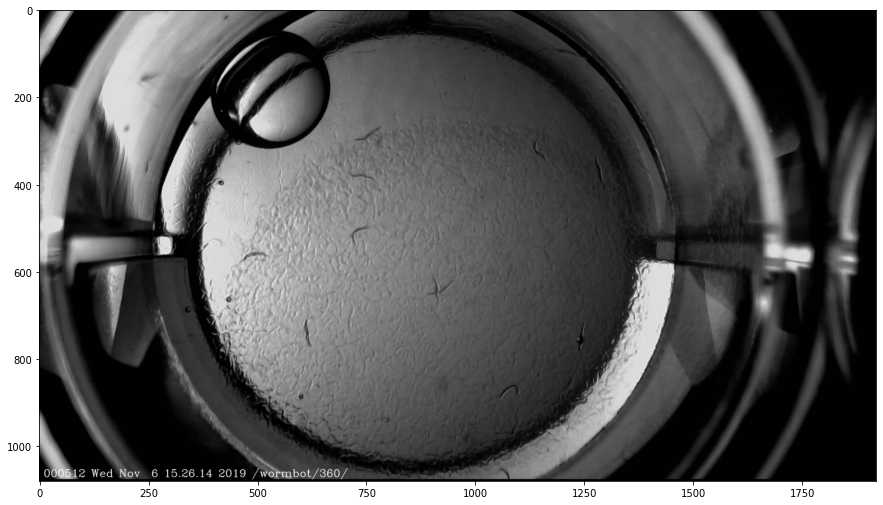

ValueError: could not convert string to float: 'dataCells3'

In [5]:
image_ar = cv2.imread(f"{IMAGE_PATH}{image_names[1]}")
image_ar_2 = cv2.imread(f"{IMAGE_PATH}{image_names[2]}")
np_im = np.array(image_ar)
plt.imshow(np_im)
plt.show()

df = pd.DataFrame(csv_ar)
df.loc[: , 1:4] = df.loc[: , 1:4].astype(float)
#df[1:] = df[1:].astype(float)
#print(df.loc[:, 0])

In [6]:
## test image from orignal csv not compiled ##
im_test = image_names[4]
base_im_test = im_test.split(".png")[0]
print(base_im_test)

full_im_test = cv2.imread(f"{IMAGE_PATH}{im_test}")

csv = f"../worm_data/test/test_csv/{base_im_test}_annotated.csv"
test_ar = load_csv(csv)
test_ar.remove(test_ar[0])
for row in test_ar:
    x,y,w,h = row[3:]
    x,y,w,h = int(x), int(y), int(w), int(h)
    x2 = x + w
    y2 = y + h
    
    cv2.rectangle(full_im_test, (x,y), (x2, y2), (255,255,0))
    
    #print(cords)
        

plt.imshow(full_im_test)
print(csv)

exp346_30


FileNotFoundError: [Errno 2] No such file or directory: '../worm_data/test/test_csv/exp346_30_annotated.csv'

In [22]:
import pickle
from collections import defaultdict

def format_data2(csv_ar):
    df_dict = defaultdict(list)
    
    for row in csv_ar:
        cords = list(map(float, row[1:]))
        df_dict[row[0]].append(cords)
    
    pickle_out = open("test.pickle", "wb")
    pickle.dump(df_dict, pickle_out)
    pickle_out.close()

format_data2(csv_ar)
#print(dict_data.popitem())
#print(len(dict_data.keys()))


exp335_243.png


538
(15, 4)
exp335_335.png


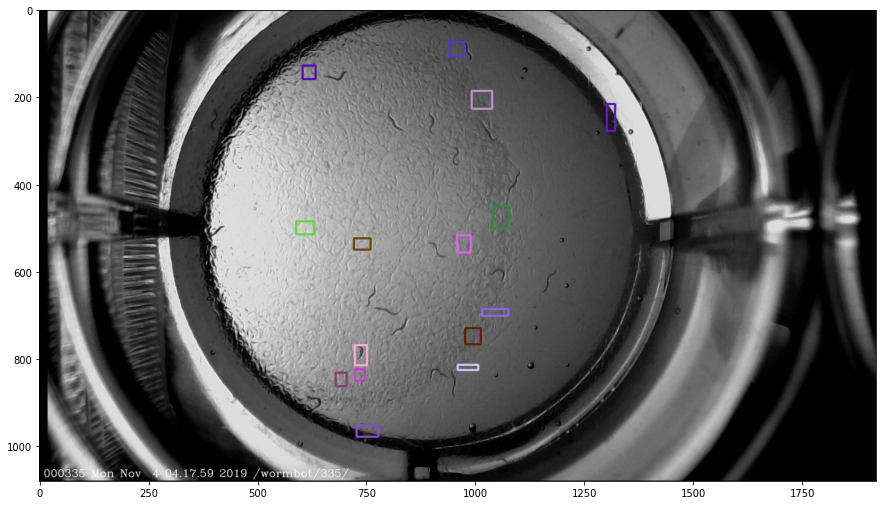

In [78]:
pickle_in = open("test.pickle", "rb")
ordered_dict = pickle.load(pickle_in)
print(len(ordered_dict.keys()))

fig,ax = plt.subplots(1)

def draw_on_image(image_name, axis=ax):
    full_im = cv2.imread(f"{IMAGE_PATH}{image_name}")
    
    im_bbs = np.asarray(ordered_dict.get(image_name)).astype(int)
    # converts to x1,y1 to x2,y2 and draws on image
    for bb in im_bbs:
        bb[2] = bb[0] + bb[2]
        bb[3] = bb[1] + bb[3]
        #print(bb)
        #print(bb[0], bb[1])
    
        #color = tuple(np.random.randint(0,255, 3))
        #rect = patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], edgecolor="r", linewidth=1, facecolor='none')
        #ax.add_patch(rect)
        #r = np.random.randint(0,255)

        r,g,b = np.random.randint(0,255, 3)
        color = (int(r),int(g), int(b))
        
        
        cv2.rectangle(full_im, (bb[0], bb[1]), (bb[2], bb[3]), (color), 4)
        
        ax.imshow(full_im)
    
    print(im_bbs.shape)
    print(image_name)
draw_on_image(image_names[15])
    


(25, 4)


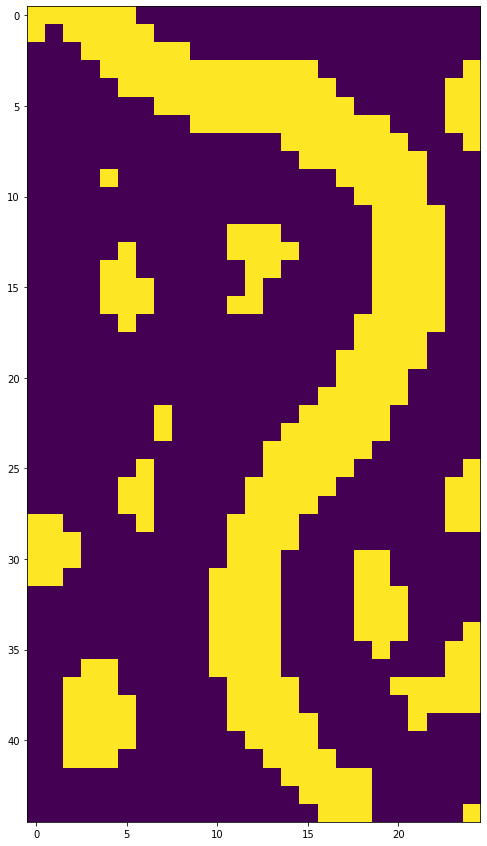

In [26]:
im_bbs = np.asarray(ordered_dict.get(image_names[9])).astype(int)
print(im_bbs.shape)
im_bbs2 = np.asarray(ordered_dict.get(image_names[9]))
#print(im_bbs)

def isolate_worm(image_name, n):
    image = cv2.imread(f"{IMAGE_PATH}{image_name}", 0)
    im_bbs = np.asarray(ordered_dict.get(image_name))
    im_bbs = im_bbs.astype("int")
    x,y,w,h = im_bbs[n]
    
    worm_bb_im = image[y:y+h, x:x+w]
    return(worm_bb_im)
    
worm = isolate_worm(image_names[9], 1)
worm_blur = cv2.GaussianBlur(worm, (5,5), 0)
thr = cv2.adaptiveThreshold(worm_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
plt.imshow(thr)
#plt.imshow(worm_blur)

In [3]:
CROP_SIZE = 352
STRIDE = 176

def downscale_bbs(bb, grid_pos):
    # input is xcenter, ycenter, width height
    # output is upper left corner, full width full height
    x, y, w, h = bb
    Xgrid, Ygrid = grid_pos
    n_x = (x-w) - Xgrid
    n_y = (y-h) - Ygrid
    adj_position = [n_x, n_y, w*2, h*2]
    return(adj_position)
    

def square_image(np_im):
    x_shape = np_im.shape[1]
    y_shape = np_im.shape[0]

    x_crop = x_shape % CROP_SIZE 
    y_crop = y_shape % CROP_SIZE

    # crop image so it is divisible by 352 
    croped_np_im = np_im[:(y_shape-y_crop), :(x_shape-x_crop)]
    return croped_np_im

def stride_image(image_name, STRIDE, ax):
    image = cv2.imread(f"{IMAGE_PATH}{image_name}")
    drawn_image = cv2.imread(f"{IMAGE_PATH}{image_name}")
    im_bbs = np.asarray(ordered_dict.get(image_name))
    
    # output dictionary with image pixles and bounding boxes
    image_slices = defaultdict()
    
    # image stuff
    x_shape = image.shape[1]
    y_shape = image.shape[0]
    
    # convert to x,y,w,h
    adj_bbs = []
    for bb in im_bbs:
        w, h = (bb[2:])/2
        adj_pos = [(bb[0]+w), (bb[1]+h), w, h]
        adj_bbs.append(adj_pos)
    
    adj_bbs = np.array(adj_bbs)
    
    # test new bbs 
    fig,ax = plt.subplots(2,1)
    ax[0].imshow(image)
    ax[1].imshow(show_image(drawn_image, adj_bbs, im_out=True))
    
    # cut the images with the given stride
    cut_images = []
    y_map = 0
    for Y in range(0, y_shape, (STRIDE)):
        #print("y:", y,(y+CROP_SIZE))
        
        x_map = 0
        for X in range(0, x_shape, (STRIDE)):  
            # cut the image
            im_slice = image[Y:Y+CROP_SIZE, X:X+CROP_SIZE]
            image_slices[(y_map, x_map)] = {"image": im_slice, "bbs":[], "cord":(X,Y)}
            
            slice_bbs = []
            for bb in adj_bbs:
                np.around(bb, 3, out=bb)
                status = bound_check(X, Y, bb[0], bb[1], bb[2], bb[3], CROP_SIZE)
                if status:
                    image_slices[(y_map, x_map)]["bbs"].append(bb)
                    #print(x_map, y_map, bb)
            
            # test draw the rectangles on the image 
            if X == 0 or X % 352 == 0:
                rect = patches.Rectangle((X,Y), 352, 352, edgecolor="b", linewidth=1, facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(X+10,Y+30, f"({x_map},{y_map})", color='blue')
            else:
                rect = patches.Rectangle((X,Y), 352, 352, edgecolor="r", linewidth=1, facecolor='none')
                ax[0].add_patch(rect)
                ax[0].text(X+10,Y+30, f"({x_map},{y_map})", color='red')
                
                
            
            
            x_map += 1
        y_map += 1
    
    print("# of boxes:",y_map*x_map)
    #return image_slices
    return (image_slices, adj_bbs)

    plt.show()
    

croped_np_im = square_image(np_im)
ims_dict, im_adj_bbs = stride_image(image_names[16], STRIDE, ax)

NameError: name 'np_im' is not defined

At this point all the slices and worm coordinates are organized into the dictionary named ims_dict. Will now work on rebuilding the image and solve the bounding box overlap issue. 

bbs are stored in x_center, y_center, width, height

NameError: name 'ims_dict' is not defined

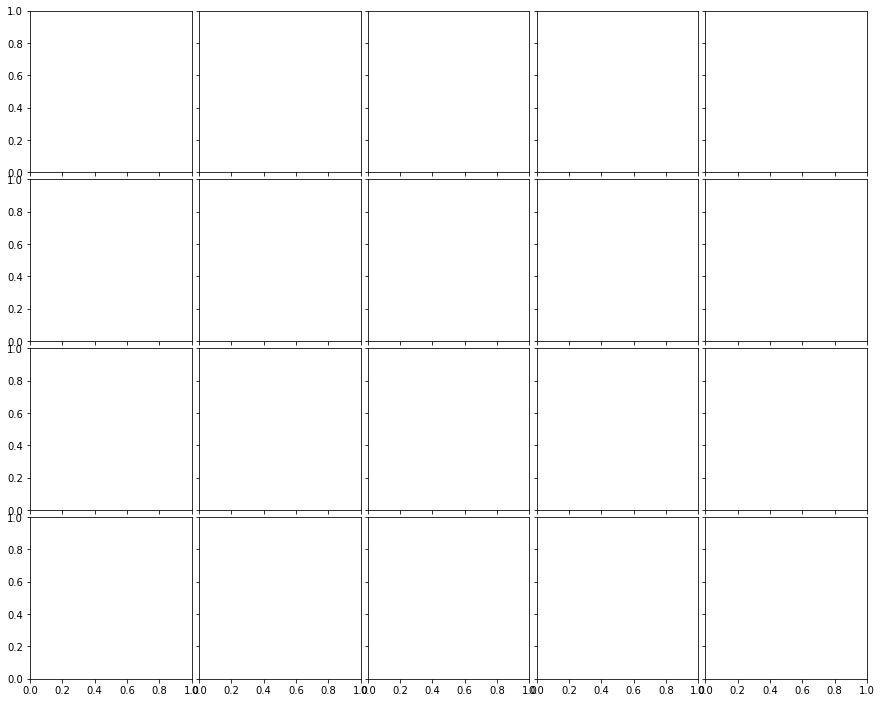

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig2 = plt.figure(figsize=(15,15))
grid = ImageGrid(fig2, 111, nrows_ncols=(4,5), axes_pad = 0.1)

y1, x1 = np.mgrid[1:5:1, 2:7:1]
x1 = x1.reshape(20)
y1 = y1.reshape(20)

map_cords = zip(y1, x1)

def simple_chart():
    for ax, cord in zip(grid, map_cords):
        grid_pos = ims_dict[cord]["cord"]
        sliced = ims_dict[cord]["image"]
        ax.imshow(sliced)
        
        bbs = ims_dict[cord]["bbs"]
        for bb in bbs:
            adj_pos = downscale_bbs(bb, grid_pos)
            x, y, w, h = adj_pos
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        
    
simple_chart()



    

In [ ]:

fig3 = plt.figure(figsize=(10,10))
grid = ImageGrid(fig3, 111, nrows_ncols=(2,2), axes_pad = 0.1)

for i, image in enumerate(image_names[0:4]):
    image_ar = cv2.imread(f"{IMAGE_PATH}{image}")
    print(image_ar.shape)
    grid[i].imshow(image_ar)




In [ ]:

test = {3:{'test':3, 'clss':2}, 4:{'test':1, 'clss':1}, 5:"y"}
print(list(test.keys()))
keys = (test.keys())

for key in keys:
    print(test[key]['test'])



In [ ]:
t

In [5]:
t , p = 0.5*np.asarray([1,2])
ar = np.asarray([1,2])


In [6]:
from collections import defaultdict
CSV_PATH = "/home/paolobif/Lab-Work/ml/pre_arch/worm_data/compiled_11_20/compiled_11_20.csv"
IMAGE_PATH = "/home/paolobif/Lab-Work/ml/pre_arch/worm_data/compiled_11_20/NN_posttrain_2_im/"
csv_ar = load_csv(CSV_PATH)
csv_ar = csv_ar[1:]
csv_ar


def dictionize_csv(csv_ar):
    dict_info = {}
    for row in csv_ar:
        img_name = row[0]
        dict_info.setdefault(img_name, []).append(row[1:])
    return dict_info

def anotate_image(img_name, img_dict):
    img = cv2.imread(IMAGE_PATH+img_name)
    bbs = img_dict[img_name]
    for bb in bbs:
        bb = [int(i) for i in bb]
        xcorner, ycorner, w, h = bb
        x1, x2 = xcorner, (xcorner + w)
        y1, y2 = ycorner, (ycorner + h)
        
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,255,0), 2)
    return img



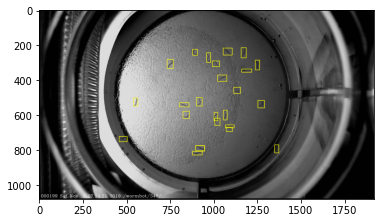

In [7]:
dict_info = dictionize_csv(csv_ar)
image_names = os.listdir(IMAGE_PATH)

img = anotate_image(image_names[70], dict_info)
plt.imshow(img)


def iterate_through_imgs(image_names, dict_info):
    i = 0 
    while True:
        img = anotate_image(image_names[i], dict_info)
        yield img
        i += 1

img = iterate_through_imgs(image_names, dict_info)

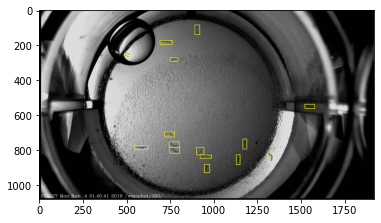

In [8]:
plt.imshow(next(img))

In [217]:
## creates grid for slicing based on input of image siz and cut sizes
img_size = (1420, 1080)
def map_grid(img_size, cut_size, shiftxy=(0,0)):
    x_size = img_size[0]
    y_size = img_size[1]    
    
    x_shift = shiftxy[0]
    y_shift = shiftxy[1]
    
    map_ar = []
    
    # declare ranges
    x_start_range = 0 + x_shift
    y_start_range = 0 + y_shift
    
    # first pass max_range 
    
    x_max_range = x_size + cut_size if shiftxy == (0,0) else x_size
    y_max_range = y_size + cut_size if shiftxy == (0,0) else y_size
    
    for x in range(0+x_shift, x_max_range, cut_size):
        for y in range(0+y_shift, y_max_range, cut_size):
            map_ar.append([x,y])
    
    return np.array(map_ar)

crop_size = 300
points = map_grid(img_size, crop_size)
points2 = map_grid(img_size, crop_size, (150,150))
points3 = map_grid(img_size, crop_size, (0,150))
points4 = map_grid(img_size, crop_size, (150,0))

points2

array([[ 150,  150],
       [ 150,  450],
       [ 150,  750],
       [ 150, 1050],
       [ 450,  150],
       [ 450,  450],
       [ 450,  750],
       [ 450, 1050],
       [ 750,  150],
       [ 750,  450],
       [ 750,  750],
       [ 750, 1050],
       [1050,  150],
       [1050,  450],
       [1050,  750],
       [1050, 1050],
       [1350,  150],
       [1350,  450],
       [1350,  750],
       [1350, 1050]])

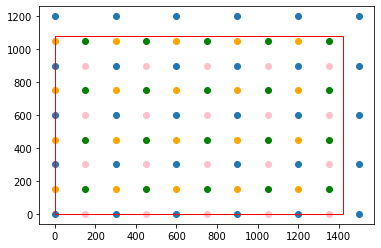

In [218]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('auto')

# fist pass
ax.scatter(points[:,0], points[:,1])

# second pass
ax.scatter(points2[:,0], points2[:,1], color="green")

#3rd pass 
ax.scatter(points3[:,0], points3[:,1], color="orange")

# 4th pass 
ax.scatter(points4[:,0], points4[:,1], color="pink")

rect = plt.Rectangle((0,0), img_size[0], img_size[1], fill=False, color='red')
ax.add_patch(rect)
plt.show()

(300, 300, 3)


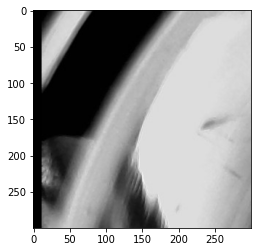

In [214]:
## padding function for images not the correct size
img_name = image_names[0]
img = cv2.imread(IMAGE_PATH+img_name)
crop = img[:300, :300]
plt.imshow(crop)

print(crop.shape)


## takes cut image and padds the remainder to fit the cut_size
def add_padding_to_square_img(img, cut_size):
    y_size, x_size = img.shape[:2]
    y_pad_amount = cut_size - y_size
    x_pad_amount = cut_size - x_size
    
    pad_img = np.pad(img, [(0,y_pad_amount), (0,x_pad_amount), (0,0)])
    
    return pad_img

pad_img = add_padding_to_square_img(crop, 300)
plt.imshow(pad_img)

In [391]:
## creates maping generator object
class Map_Generator():
    """ Class generates a map grid with the specified cuts
        Takes an imput of either image or xy tuple"""
    def __init__(self, xy_shape, cut_size):
        self.cut_size = cut_size
        if type(xy_shape) != tuple:
            print("Warning! input must be an np img array")
            self.xy_shape = (xy_shape.shape[1], xy_shape.shape[0])
            #self.x_shape = img_xy.shape[1]
        else:
            self.xy_shape = xy_shape
            #self.y_shape = img_xy[1]
        
        self.paired_grid = []
        
        self.map_grid = self.generate_complete_map_grid()
    
    def generate_complete_map_grid(self):
        """Four passes of map_grid need to be run in order
        to cover entire area. Returns list of points for bounds. """
        xy_shape = self.xy_shape
        cut_size = self.cut_size
        
        shiftx = int(self.cut_size/2) 
        shifty = int(self.cut_size/2)
        
        pass1 = self.map_ar(xy_shape, cut_size, (0,0))
        pass2 = self.map_ar(xy_shape, cut_size, (shiftx, shifty))
        pass3 = self.map_ar(xy_shape, cut_size, (shiftx, 0))
        pass4 = self.map_ar(xy_shape, cut_size, (0, shifty))
        self.map_grids = [pass1, pass2, pass3, pass4]
        
        complete_map_grid = []
        for map_grid in self.map_grids:
            paired_corners = self.convert_grid_to_cornerxy(map_grid)
            self.paired_grid.append(paired_corners)
            complete_map_grid.extend(paired_corners)
            
        return complete_map_grid
        
        # shiftxy can be modified when calling map_ar to create different arrangements of rectangles
        
    @staticmethod
    def map_ar(xy_shape, cut_size, shiftxy=(0,0)):
        """creates grid map for slicing - adjust shift to cover needed areas -current method
        is shift=(cut_size/2, cut_size/2) and (0, cut_size/2) and (cut_size, 0/2).
        IMPORTANT - cut_size must be div by 2"""
        x_size = xy_shape[0]
        y_size = xy_shape[1]    

        x_shift = shiftxy[0]
        y_shift = shiftxy[1]

        map_ar = []

        # declare ranges
        x_start_range = 0 + x_shift
        y_start_range = 0 + y_shift

        # determines the range of each cut. 
        second_pass_shift = (int(cut_size/2), int(cut_size/2)) 
        x_max_range = x_size + cut_size if shiftxy == (0,0) or shiftxy == second_pass_shift else x_size
        y_max_range = y_size + cut_size if shiftxy == (0,0) or shiftxy == second_pass_shift else y_size

        for x in range(0+x_shift, x_max_range, cut_size):
            for y in range(0+y_shift, y_max_range, cut_size):
                map_ar.append([x,y])

        return map_ar
    
    @staticmethod
    def convert_grid_to_cornerxy(map_grid):
        """ Takes the series of points and then returns point (x1,y1), (x2,y2) for each rectangle"""
        only_xs = [n[0] for n in map_grid]
        y_slice_count = only_xs.count(only_xs[0])
               
        paired_corners = []
        ## pair index is the matching corner to point
        for i, point in enumerate(map_grid):
            pair_index = i+y_slice_count+1
            
            # if the pair index is not the last of each chunck or the last group do ...
            if (i+1) % y_slice_count != 0 and pair_index <= len(map_grid):
                #print(i, pair_index, f"division:{(i+1)%y_slice_count}")
                pair = map_grid[pair_index]
                paired_corners.append([tuple(point), tuple(pair)])
            else:
                pass
            
        return(paired_corners)
        

In [392]:
## reformats pair in map_ar
def convert_xypair_to_xy_wh(paired_corners):
    """ Calculates difference between paired corners to get w and h
    then makes new list using index = 0 of each pair and the w & h"""
    xy_wh_map = []
    for pair in paired_corners:
        x1y1, x2y2 = pair[0], pair[1]
        wh = tuple(map(lambda i,j: i-j, x2y2, x1y1))
        xy_wh_map.append([x1y1, wh])
    
    return(xy_wh_map)


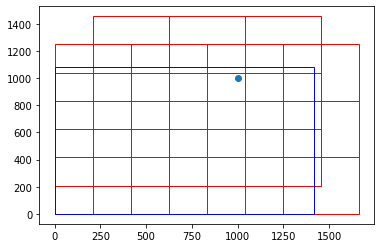

In [393]:
map_grid = Map_Generator(img_size, 416).map_grid
xy_wh_rects = convert_xypair_to_xy_wh(map_grid)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax.axis('auto')

for rect in xy_wh_rects:
    xy = rect[0]
    wh = rect[1]
    rectangle = plt.Rectangle(xy, wh[0], wh[1], fill=False, color="red")
    ax2.add_patch(rectangle)

img_rect = plt.Rectangle((0,0), img_size[0], img_size[1], fill=False, color='blue', )
ax2.add_patch(img_rect)

ax2.scatter(1000,1000)
plt.show()

[[[(0, 0), (416, 416)], [(0, 416), (416, 832)], [(0, 832), (416, 1248)], [(416, 0), (832, 416)], [(416, 416), (832, 832)], [(416, 832), (832, 1248)], [(832, 0), (1248, 416)], [(832, 416), (1248, 832)], [(832, 832), (1248, 1248)], [(1248, 0), (1664, 416)], [(1248, 416), (1664, 832)], [(1248, 832), (1664, 1248)]], [[(208, 208), (624, 624)], [(208, 624), (624, 1040)], [(208, 1040), (624, 1456)], [(624, 208), (1040, 624)], [(624, 624), (1040, 1040)], [(624, 1040), (1040, 1456)], [(1040, 208), (1456, 624)], [(1040, 624), (1456, 1040)], [(1040, 1040), (1456, 1456)]], [[(208, 0), (624, 416)], [(208, 416), (624, 832)], [(624, 0), (1040, 416)], [(624, 416), (1040, 832)]], [[(0, 208), (416, 624)], [(0, 624), (416, 1040)], [(416, 208), (832, 624)], [(416, 624), (832, 1040)], [(832, 208), (1248, 624)], [(832, 624), (1248, 1040)]]]


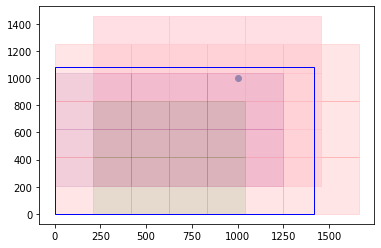

In [403]:
map_grids = Map_Generator(img_size, 416).paired_grid
print(map_grids)
grid1 = map_grids[1]
grid2 = map_grids[2]
grid3 = map_grids[3]
grid0 = map_grids[0]


fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.axis('auto')

def add_pathces(grid, ax, color="r", alpha=1):
    xywh = convert_xypair_to_xy_wh(grid)
    for rect in xywh:
        xy = rect[0]
        wh = rect[1]
        rectangle = plt.Rectangle(xy, wh[0], wh[1], color=color, alpha=alpha)
        ax.add_patch(rectangle)

add_pathces(grid0, ax2, color="r", alpha=0.1)
add_pathces(grid1, ax2, color="pink", alpha = 0.5)
add_pathces(grid2, ax2, color="green", alpha = 0.1)
add_pathces(grid3, ax2, color="purple", alpha = 0.1)

img_rect = plt.Rectangle((0,0), img_size[0], img_size[1], fill=False, color='blue', )
ax2.add_patch(img_rect)

ax2.scatter(1000,1000)
plt.show()

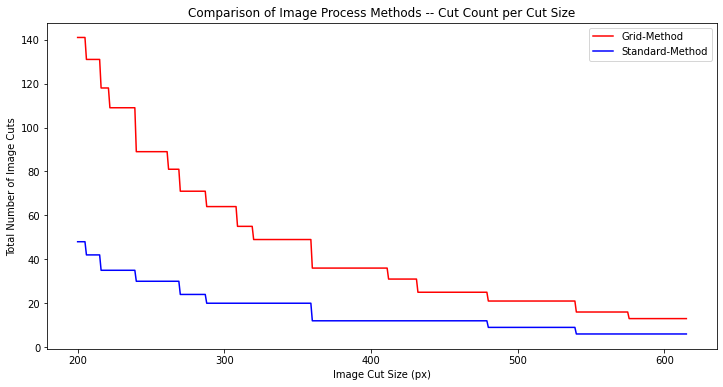

In [466]:
### now graphing to find optimal cut size to minimize grid count
def get_grid_count(img_size, cut_size):
    map_grid = Map_Generator(img_size, cut_size)
    all_grids = map_grid.map_grid
    single_grid = map_grid.paired_grid[0]
    
    return(len(all_grids), len(single_grid))
    

fig2 = plt.figure(figsize=(12,6))
ax2 = fig2.add_subplot(111)
ax2.axis('auto')
ax2.set_title("Comparison of Image Process Methods -- Cut Count per Cut Size")
ax2.set_xlabel("Image Cut Size (px)")
ax2.set_ylabel("Total Number of Image Cuts")

scattered = []
single = []
for cut_size in range(200,616,1):
    scat, sing = get_grid_count((1080,1440), cut_size)
    scattered.append((cut_size, scat))
    single.append((cut_size, sing))

#scattered
scat_xs = [n[0] for n in scattered]
scat_ys = [n[1] for n in scattered]

#single
sing_xs = [n[0] for n in single]
sing_ys = [n[1] for n in single]

#plot
ax2.plot(scat_xs, scat_ys, color = 'red', label="Grid-Method")
ax2.plot(sing_xs, sing_ys, color = 'b', label="Standard-Method")
ax2.legend()

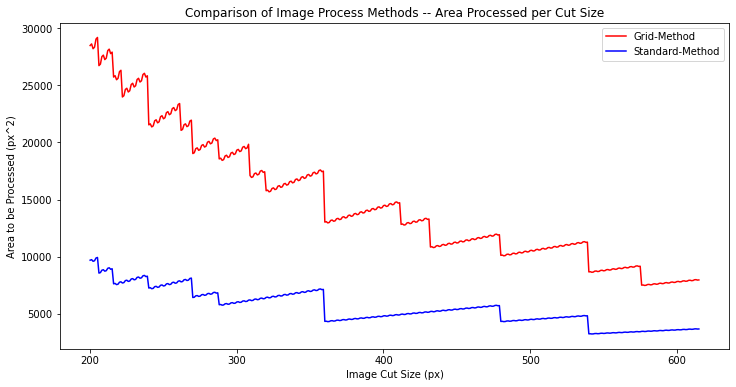

In [467]:
fig2 = plt.figure(figsize=(12,6))
ax2 = fig2.add_subplot(111)
ax2.axis('auto')
ax2.set_title("Comparison of Image Process Methods -- Area Processed per Cut Size")
ax2.set_xlabel("Image Cut Size (px)")
ax2.set_ylabel("Area to be Processed (px^2)")

scattered = []
single = []
for cut_size in range(200,616,1):
    scat, sing = get_grid_count((1080,1440), cut_size)
    scat_area = (cut_size^2) * scat
    sing_area = (cut_size^2) * sing
    
    scattered.append((cut_size, scat_area))
    single.append((cut_size, sing_area))

    #single
sing_xs = [n[0] for n in single]
sing_ys = [n[1] for n in single]

#scattered
scat_xs = [n[0] for n in scattered]
scat_ys = [n[1] for n in scattered]

#plot
ax2.plot(scat_xs, scat_ys, color = 'red', label="Grid-Method")
ax2.plot(sing_xs, sing_ys, color = 'b', label="Standard-Method")
ax2.legend()